# *Importación de Librerías*

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
import os, keras
import pandas as pd
import numpy as np
from PIL import Image

#LIBRERIAS TENSOR

from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam

#LIBRERIAS KERAS
from keras.layers import Conv2D,  MaxPooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization, Input
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
#from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.mobilenet import MobileNet


#LIBRERIAS TENSOR
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# *Dirección de las fotos de entrenamiento y validación*

In [15]:
K.clear_session() #Limpiamos todo en caso de un nuevo entrenamiento
data_entrenamiento='C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/entrenamiento'
data_validacion='C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/validacion'

# *Hiperparámetros*

In [16]:
#Hiperparámetros
epocas=5
num_clases=15
altura=227
ancho=227
altura_1=224
ancho_1=224
batch_size=20
lr=0.0005

# *Preparación de las imágenes*

In [17]:
entrenamiento_datagen= ImageDataGenerator()
validacion_datagen=ImageDataGenerator()

#Va abrir y preparar toda la carpeta de entrenamiento
imagen_entrenamiento=entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura_1,ancho_1),
    batch_size=batch_size,
    class_mode='categorical')

#Va abrir y preparar toda la carpeta de validacion
imagen_validacion=validacion_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura_1,ancho_1),
    batch_size=batch_size,
    class_mode='categorical')

print(imagen_entrenamiento.class_indices)


Found 2100 images belonging to 15 classes.
Found 600 images belonging to 15 classes.
{'angel': 0, 'angeliz': 1, 'carlos': 2, 'carlosiz': 3, 'elsa': 4, 'elvira': 5, 'elviraiz': 6, 'erli': 7, 'erliiz': 8, 'irma': 9, 'irmaiz': 10, 'lety': 11, 'letyiz': 12, 'sergio': 13, 'sergioiz': 14}


In [18]:
pasos_entrenamiento=imagen_entrenamiento.n//imagen_entrenamiento.batch_size
pasos_validacion=imagen_validacion.n//imagen_validacion.batch_size

# *VGG16*

## Elaboración del Modelo

In [9]:
image_input = Input(shape=(altura_1,ancho_1, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model.summary()

last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
#x = Dense(128, activation='relu', name='fc1')(x)
#x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_clases, activation='softmax', name='output')(last_layer)
modeloVGG16_LC = Model(image_input, out)
modeloVGG16_LC.summary()

# congelamos todas las capas, excepto las capas densas
# for layer in modeloVGG16_LC.layers[:-3]:
# 	layer.trainable = False

# modeloVGG16_LC.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Entrenamiento del Modelo

In [10]:
modeloVGG16_LC.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=lr),metrics=['accuracy'])
modeloVGG16_LC_history = modeloVGG16_LC.fit(imagen_entrenamiento,steps_per_epoch=pasos_entrenamiento,
            epochs=epocas,validation_data=imagen_validacion,
            validation_steps=pasos_validacion)

Epoch 1/5
105/105 [==============================] - 2623s 25s/step - loss: 0.5127 - accuracy: 0.8724 - val_loss: 0.0267 - val_accuracy: 0.9967
Epoch 2/5
105/105 [==============================] - 2685s 26s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9967
Epoch 3/5
105/105 [==============================] - 2565s 24s/step - loss: 7.6353e-04 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 0.9983
Epoch 4/5
105/105 [==============================] - 2560s 24s/step - loss: 4.9069e-04 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9967
Epoch 5/5
105/105 [==============================] - 2555s 24s/step - loss: 3.5676e-04 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9983


## Gráfica de entrenamiento y validación

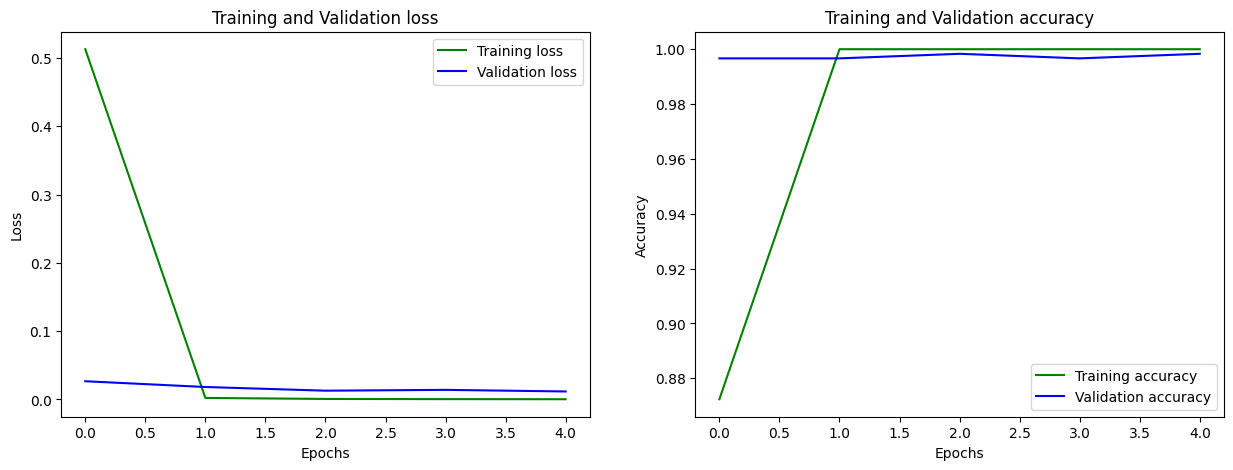

In [11]:
loss_train = modeloVGG16_LC_history.history['loss']
loss_val = modeloVGG16_LC_history.history['val_loss']
acc_train = modeloVGG16_LC_history.history['accuracy']
acc_val = modeloVGG16_LC_history.history['val_accuracy']
plt.figure(figsize=(15,5))
epochs = range(0,epocas)

plt.subplot(121)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Guardado del modelo con sus respectivos pesos

In [13]:
target_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modeloVGG16_LC.save('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloVGG16_LC.h5')
modeloVGG16_LC.save_weights('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosVGG16_LC.h5')

## Matriz de confusión

Found 300 images belonging to 15 classes.


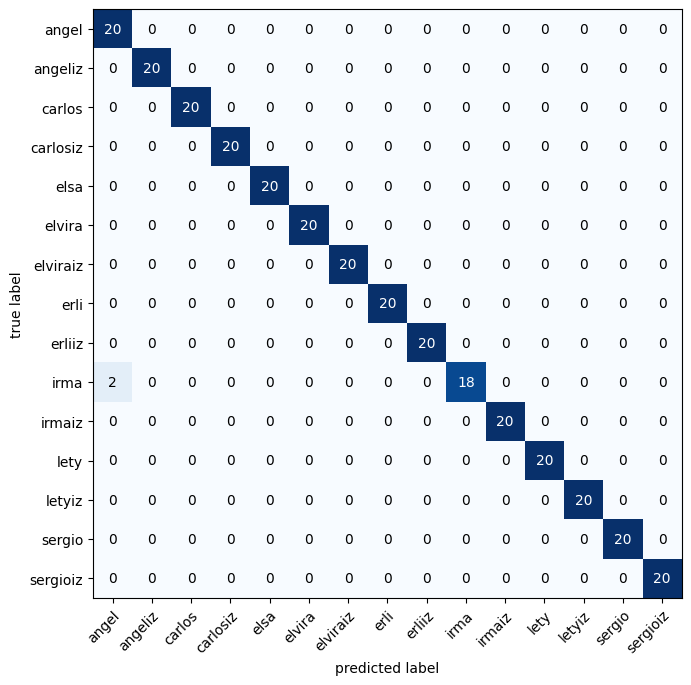

In [14]:
width_shape = 224
height_shape = 224
batch_size = 20
modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloVGG16_LC.h5'
pesos_modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosVGG16_LC.h5'
model = load_model(modelo)
model.load_weights(pesos_modelo)
names = ['angel','angeliz','carlos','carlosiz','elsa','elvira','elviraiz','erli','erliiz','irma','irmaiz','lety','letyiz','sergio','sergioiz']

test_data_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/pruebas'
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(width_shape,height_shape),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',shuffle=False)
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
#print(y_pred)
matc=confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(7,7), class_names =names, show_normed=False)
plt.tight_layout()

## Precisión de cada clase

In [15]:
print(metrics.classification_report(y_real,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524        20
           1     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     1.0000    1.0000    1.0000        20
           4     1.0000    1.0000    1.0000        20
           5     1.0000    1.0000    1.0000        20
           6     1.0000    1.0000    1.0000        20
           7     1.0000    1.0000    1.0000        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    0.9000    0.9474        20
          10     1.0000    1.0000    1.0000        20
          11     1.0000    1.0000    1.0000        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    1.0000    1.0000        20
          14     1.0000    1.0000    1.0000        20

    accuracy                         0.9933       300
   macro avg     0.9939    0.9933    0.9933       300
weighted avg     0.9939   

# *VGG16 - Fine Tune*

## Elaboración del Modelo

In [19]:
image_input = Input(shape=(altura_1,ancho_1, 3))

model2 = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model2.summary()

last_layer = model2.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_clases, activation='softmax', name='output')(x)
modeloVGG16_LC_FT = Model(image_input, out)
modeloVGG16_LC_FT.summary()

# congelamos todas las capas, excepto las capas densas
for layer in modeloVGG16_LC_FT.layers[:-3]:
	layer.trainable = False

modeloVGG16_LC_FT.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Entrenamiento del Modelo

In [20]:
modeloVGG16_LC_FT.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=lr),metrics=['accuracy'])
modeloVGG16_LC_FT_history = modeloVGG16_LC_FT.fit(imagen_entrenamiento,steps_per_epoch=pasos_entrenamiento,
            epochs=epocas,validation_data=imagen_validacion,
            validation_steps=pasos_validacion)

Epoch 1/5
105/105 [==============================] - 824s 8s/step - loss: 0.8211 - accuracy: 0.9143 - val_loss: 0.1243 - val_accuracy: 0.9517
Epoch 2/5
105/105 [==============================] - 877s 8s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9667
Epoch 3/5
105/105 [==============================] - 876s 8s/step - loss: 6.6795e-04 - accuracy: 1.0000 - val_loss: 0.0735 - val_accuracy: 0.9750
Epoch 4/5
105/105 [==============================] - 867s 8s/step - loss: 4.6857e-04 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9750
Epoch 5/5
105/105 [==============================] - 870s 8s/step - loss: 3.8641e-04 - accuracy: 1.0000 - val_loss: 0.0623 - val_accuracy: 0.9750


## Gráfica de entrenamiento y validación

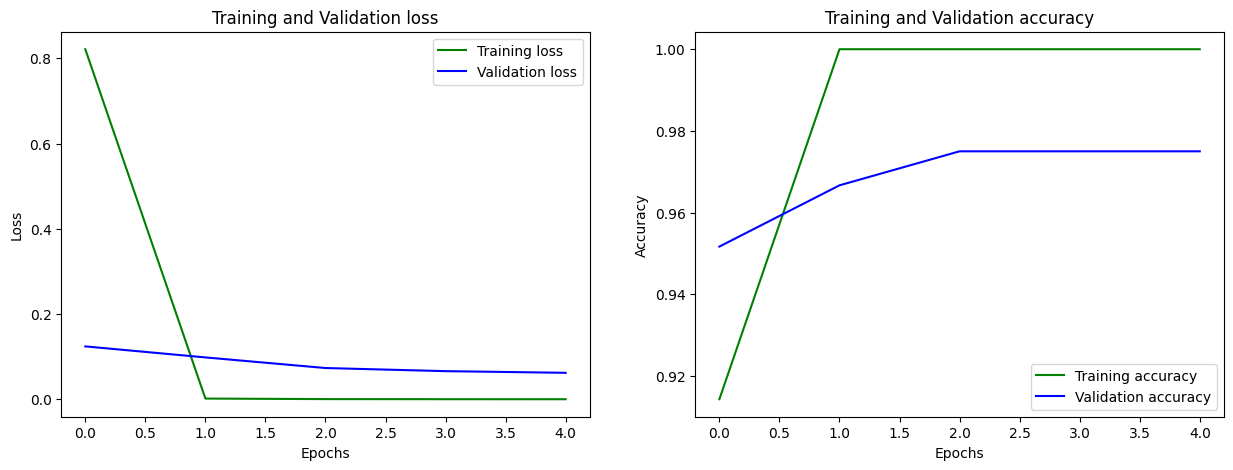

In [21]:
loss_train = modeloVGG16_LC_FT_history.history['loss']
loss_val = modeloVGG16_LC_FT_history.history['val_loss']
acc_train = modeloVGG16_LC_FT_history.history['accuracy']
acc_val = modeloVGG16_LC_FT_history.history['val_accuracy']
plt.figure(figsize=(15,5))
epochs = range(0,epocas)

plt.subplot(121)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Guardado del modelo con sus respectivos pesos

In [24]:
target_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/4. Pesos Fine Tune'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modeloVGG16_LC_FT.save('C:/Users/Angel Terrones/Desktop/TESIS/4. Pesos Fine Tune/LC/modeloVGG16_FT_LC.h5')
modeloVGG16_LC_FT.save_weights('C:/Users/Angel Terrones/Desktop/TESIS/4. Pesos Fine Tune/LC/pesosVGG16_FT_LC.h5')

## Matriz de confusión

Found 300 images belonging to 15 classes.


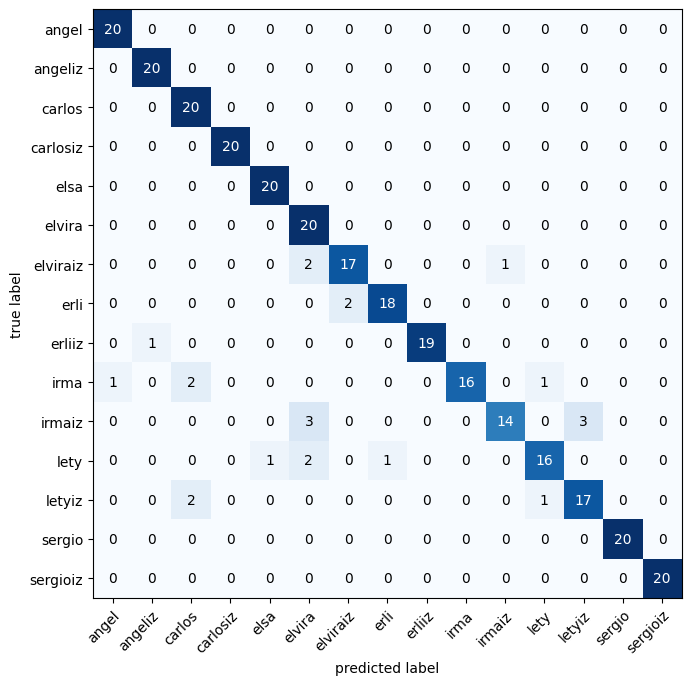

In [26]:
width_shape = 224
height_shape = 224
batch_size = 20
modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/4. Pesos Fine Tune/LC/modeloVGG16_FT_LC.h5'
pesos_modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/4. Pesos Fine Tune/LC/pesosVGG16_FT_LC.h5'
model = load_model(modelo)
model.load_weights(pesos_modelo)
names = ['angel','angeliz','carlos','carlosiz','elsa','elvira','elviraiz','erli','erliiz','irma','irmaiz','lety','letyiz','sergio','sergioiz']

test_data_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/pruebas'  
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(width_shape,height_shape),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',shuffle=False)
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
#print(y_pred)
matc=confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(7,7), class_names =names, show_normed=False)
plt.tight_layout()

## Precisión de cada clase

In [27]:
print(metrics.classification_report(y_real,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9524    1.0000    0.9756        20
           1     0.9524    1.0000    0.9756        20
           2     0.8333    1.0000    0.9091        20
           3     1.0000    1.0000    1.0000        20
           4     0.9524    1.0000    0.9756        20
           5     0.7407    1.0000    0.8511        20
           6     0.8947    0.8500    0.8718        20
           7     0.9474    0.9000    0.9231        20
           8     1.0000    0.9500    0.9744        20
           9     1.0000    0.8000    0.8889        20
          10     0.9333    0.7000    0.8000        20
          11     0.8889    0.8000    0.8421        20
          12     0.8500    0.8500    0.8500        20
          13     1.0000    1.0000    1.0000        20
          14     1.0000    1.0000    1.0000        20

    accuracy                         0.9233       300
   macro avg     0.9297    0.9233    0.9225       300
weighted avg     0.9297   

# *VGG19*

## Elaboración del Modelo

In [5]:
image_input = Input(shape=(altura_1, ancho_1, 3))

m_VGG19 = VGG19(input_tensor=image_input, include_top=False,weights='imagenet')

m_VGG19.summary()

last_layer = m_VGG19.layers[-1].output
x= Flatten(name='flatten')(last_layer)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x=Dropout(0.3)(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
# x=Dropout(0.3)(x)

out = Dense(num_clases, activation='softmax', name='output')(x)
modeloVGG19_LC = Model(image_input, out)
modeloVGG19_LC.summary()

# # freeze all the layers except the dense layers
# for layer in modeloVGG19_FT_CT.layers[:-6]:
# 	layer.trainable = False

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Entrenamiento del Modelo

In [8]:
modeloVGG19_LC.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=lr),metrics=['accuracy'])
modeloVGG19_LC_history = modeloVGG19_LC.fit(imagen_entrenamiento,steps_per_epoch=pasos_entrenamiento,
            epochs=epocas,validation_data=imagen_validacion,
            validation_steps=pasos_validacion)

Epoch 1/5
105/105 [==============================] - 3013s 29s/step - loss: 1.3663 - accuracy: 0.8900 - val_loss: 0.0522 - val_accuracy: 0.9833
Epoch 2/5
105/105 [==============================] - 3058s 29s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 0.9967
Epoch 3/5
105/105 [==============================] - 3048s 29s/step - loss: 5.3083e-04 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 4/5
105/105 [==============================] - 3059s 29s/step - loss: 3.5284e-04 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 5/5
105/105 [==============================] - 3060s 29s/step - loss: 2.6620e-04 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 1.0000


## Gráfica de entrenamiento y validación

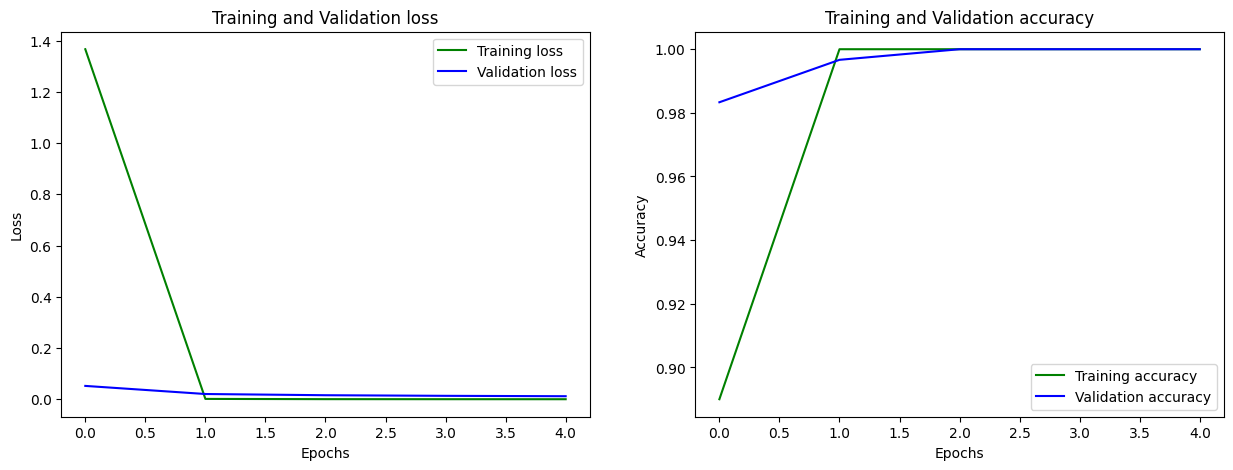

In [9]:
loss_train = modeloVGG19_LC_history.history['loss']
loss_val = modeloVGG19_LC_history.history['val_loss']
acc_train = modeloVGG19_LC_history.history['accuracy']
acc_val = modeloVGG19_LC_history.history['val_accuracy']
plt.figure(figsize=(15,5))
epochs = range(0,epocas)

plt.subplot(121)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Guardado del modelo con sus respectivos pesos

In [10]:
target_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modeloVGG19_LC.save('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloVGG19_LC.h5')
modeloVGG19_LC.save_weights('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosVGG19_LC.h5')

## Matriz de confusión

Found 300 images belonging to 15 classes.


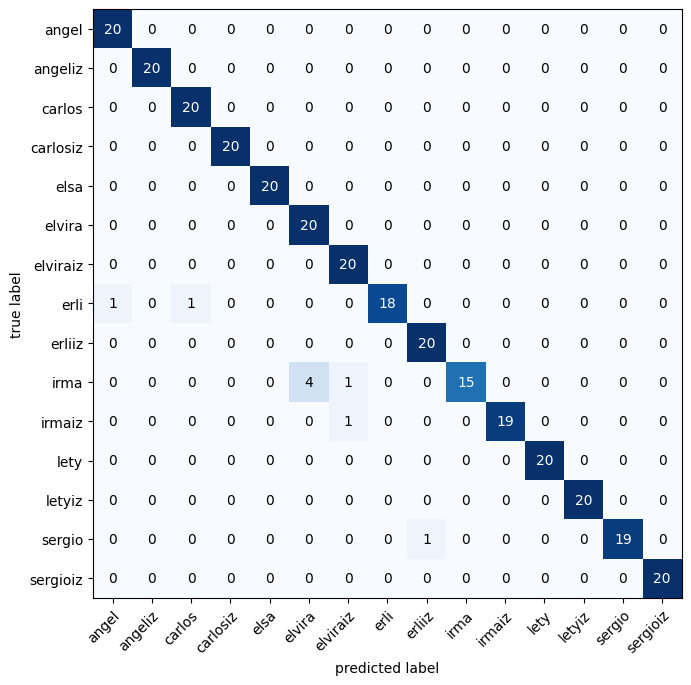

In [11]:
width_shape = 224
height_shape = 224
batch_size = 20
modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloVGG19_LC.h5'
pesos_modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosVGG19_LC.h5'
model = load_model(modelo)
model.load_weights(pesos_modelo)
names = ['angel','angeliz','carlos','carlosiz','elsa','elvira','elviraiz','erli','erliiz','irma','irmaiz','lety','letyiz','sergio','sergioiz']

test_data_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/pruebas'  
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(width_shape,height_shape),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',shuffle=False)
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
#print(y_pred)
matc=confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(7,7), class_names =names, show_normed=False)
plt.tight_layout()

## Precisión de cada clase

In [12]:
print(metrics.classification_report(y_real,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9524    1.0000    0.9756        20
           1     1.0000    1.0000    1.0000        20
           2     0.9524    1.0000    0.9756        20
           3     1.0000    1.0000    1.0000        20
           4     1.0000    1.0000    1.0000        20
           5     0.8333    1.0000    0.9091        20
           6     0.9091    1.0000    0.9524        20
           7     1.0000    0.9000    0.9474        20
           8     0.9524    1.0000    0.9756        20
           9     1.0000    0.7500    0.8571        20
          10     1.0000    0.9500    0.9744        20
          11     1.0000    1.0000    1.0000        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    0.9500    0.9744        20
          14     1.0000    1.0000    1.0000        20

    accuracy                         0.9700       300
   macro avg     0.9733    0.9700    0.9694       300
weighted avg     0.9733   

# *VGG19 - Fine Tune*

## Elaboración del Modelo

In [6]:
image_input = Input(shape=(altura_1, ancho_1, 3))

m_VGG19 = VGG19(input_tensor=image_input, include_top=False,weights='imagenet')

m_VGG19.summary()

last_layer = m_VGG19.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_clases, activation='softmax', name='output')(x)
modeloVGG19_LC_FT = Model(image_input, out)
modeloVGG19_LC_FT.summary()

# freeze all the layers except the dense layers
for layer in modeloVGG19_LC_FT.layers[:-6]:
	layer.trainable = False

modeloVGG19_LC_FT.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Entrenamiento del Modelo

In [8]:
modeloVGG19_LC_FT.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=lr),metrics=['accuracy'])
modeloVGG19_LC_FT_history = modeloVGG19_LC_FT.fit(imagen_entrenamiento,steps_per_epoch=pasos_entrenamiento,
            epochs=epocas,validation_data=imagen_validacion,
            validation_steps=pasos_validacion)

Epoch 1/5
105/105 [==============================] - 1059s 10s/step - loss: 1.7186 - accuracy: 0.6148 - val_loss: 0.0513 - val_accuracy: 0.9883
Epoch 2/5
105/105 [==============================] - 1103s 11s/step - loss: 0.6625 - accuracy: 0.8243 - val_loss: 0.0266 - val_accuracy: 0.9950
Epoch 3/5
105/105 [==============================] - 1106s 11s/step - loss: 0.3836 - accuracy: 0.8857 - val_loss: 0.0079 - val_accuracy: 0.9967
Epoch 4/5
105/105 [==============================] - 1112s 11s/step - loss: 0.3129 - accuracy: 0.9119 - val_loss: 9.2386e-04 - val_accuracy: 1.0000
Epoch 5/5
105/105 [==============================] - 1101s 11s/step - loss: 0.2242 - accuracy: 0.9348 - val_loss: 7.2133e-04 - val_accuracy: 1.0000


## Gráfica de entrenamiento y validación

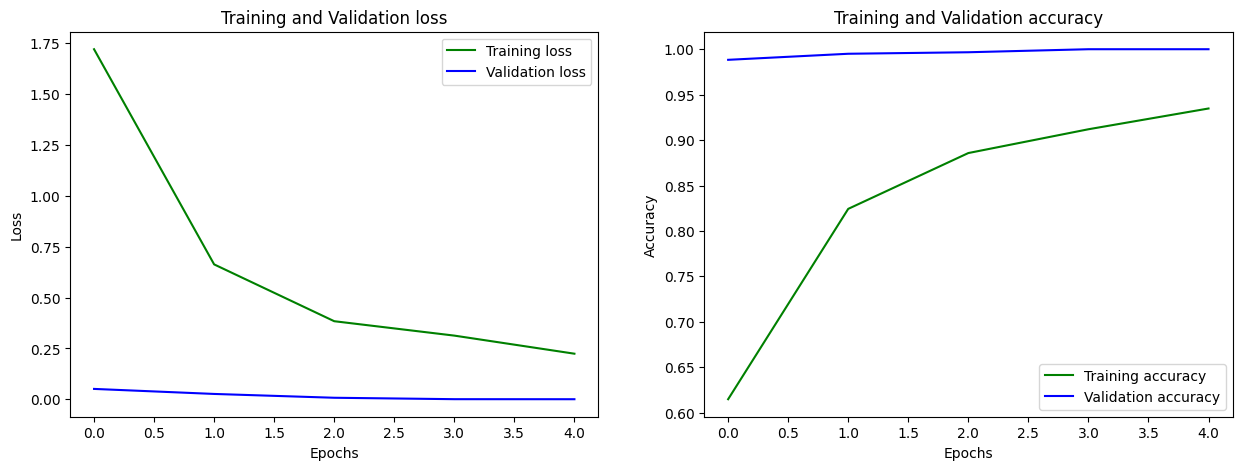

In [9]:
loss_train = modeloVGG19_LC_FT_history.history['loss']
loss_val = modeloVGG19_LC_FT_history.history['val_loss']
acc_train = modeloVGG19_LC_FT_history.history['accuracy']
acc_val = modeloVGG19_LC_FT_history.history['val_accuracy']
plt.figure(figsize=(15,5))
epochs = range(0,epocas)

plt.subplot(121)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Guardado del modelo con sus respectivos pesos

In [11]:
target_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modeloVGG19_LC_FT.save('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloVGG19_LC_FT.h5')
modeloVGG19_LC_FT.save_weights('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosVGG19_LC_FT.h5')

## Matriz de confusión

Found 300 images belonging to 15 classes.


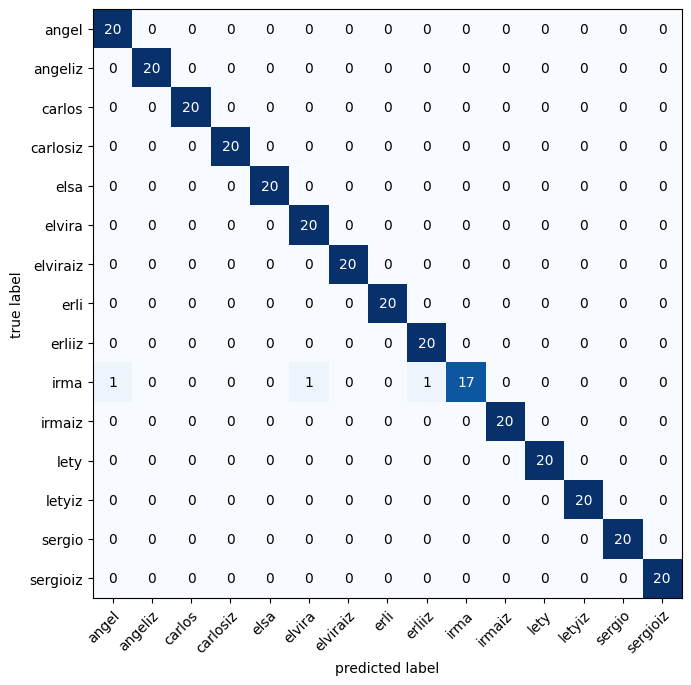

In [12]:
width_shape = 224
height_shape = 224
batch_size = 20
modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloVGG19_LC_FT.h5'
pesos_modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosVGG19_LC_FT.h5'
model = load_model(modelo)
model.load_weights(pesos_modelo)
names = ['angel','angeliz','carlos','carlosiz','elsa','elvira','elviraiz','erli','erliiz','irma','irmaiz','lety','letyiz','sergio','sergioiz']

test_data_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/pruebas'  
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(width_shape,height_shape),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',shuffle=False)
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
#print(y_pred)
matc=confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(7,7), class_names =names, show_normed=False)
plt.tight_layout()

## Precisión de cada clase

In [13]:
print(metrics.classification_report(y_real,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9524    1.0000    0.9756        20
           1     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     1.0000    1.0000    1.0000        20
           4     1.0000    1.0000    1.0000        20
           5     0.9524    1.0000    0.9756        20
           6     1.0000    1.0000    1.0000        20
           7     1.0000    1.0000    1.0000        20
           8     0.9524    1.0000    0.9756        20
           9     1.0000    0.8500    0.9189        20
          10     1.0000    1.0000    1.0000        20
          11     1.0000    1.0000    1.0000        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    1.0000    1.0000        20
          14     1.0000    1.0000    1.0000        20

    accuracy                         0.9900       300
   macro avg     0.9905    0.9900    0.9897       300
weighted avg     0.9905   

# *Mobilenet*

## Elaboración del Modelo

In [26]:
image_input = Input(shape=(altura_1, ancho_1, 3))

m_MobileNet = MobileNet(input_tensor=image_input, include_top=False,weights='imagenet')

m_MobileNet.summary()

last_layer = m_MobileNet.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_clases, activation='softmax', name='output')(x)

modeloMobileNet_LC = Model(image_input, out)
modeloMobileNet_LC.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

## Entrenamiento del Modelo

In [27]:
modeloMobileNet_LC.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=lr),metrics=['accuracy'])
modeloMobileNet_LC_history = modeloMobileNet_LC.fit(imagen_entrenamiento,steps_per_epoch=pasos_entrenamiento,
            epochs=epocas,validation_data=imagen_validacion,
            validation_steps=pasos_validacion)

Epoch 1/5
105/105 [==============================] - 240s 2s/step - loss: 1.6970 - accuracy: 0.5029 - val_loss: 1.2029 - val_accuracy: 0.7367
Epoch 2/5
105/105 [==============================] - 249s 2s/step - loss: 0.3784 - accuracy: 0.8910 - val_loss: 0.1728 - val_accuracy: 0.9983
Epoch 3/5
105/105 [==============================] - 251s 2s/step - loss: 0.2109 - accuracy: 0.9424 - val_loss: 0.0602 - val_accuracy: 1.0000
Epoch 4/5
105/105 [==============================] - 252s 2s/step - loss: 0.1262 - accuracy: 0.9633 - val_loss: 0.0199 - val_accuracy: 0.9983
Epoch 5/5
105/105 [==============================] - 254s 2s/step - loss: 0.0985 - accuracy: 0.9767 - val_loss: 0.0073 - val_accuracy: 1.0000


## Gráfica de entrenamiento y validación

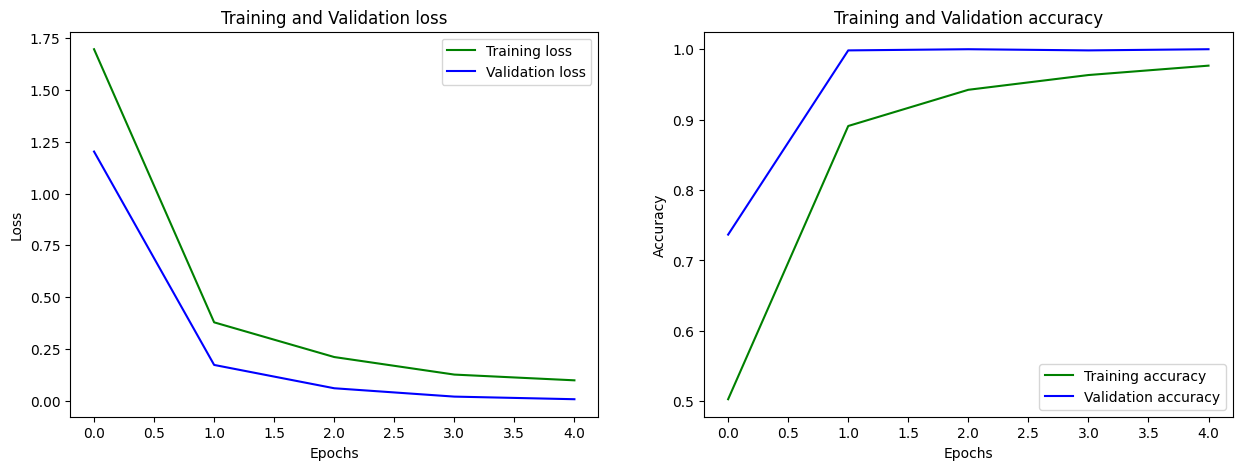

In [28]:
loss_train = modeloMobileNet_LC_history.history['loss']
loss_val = modeloMobileNet_LC_history.history['val_loss']
acc_train = modeloMobileNet_LC_history.history['accuracy']
acc_val = modeloMobileNet_LC_history.history['val_accuracy']
plt.figure(figsize=(15,5))
epochs = range(0,epocas)

plt.subplot(121)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Guardado del modelo con sus respectivos pesos

In [31]:
target_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modeloMobileNet_LC.save('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloMobileNet_LC.h5')
modeloMobileNet_LC.save_weights('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosMobileNet_LC.h5')

## Matriz de confusión

Found 300 images belonging to 15 classes.


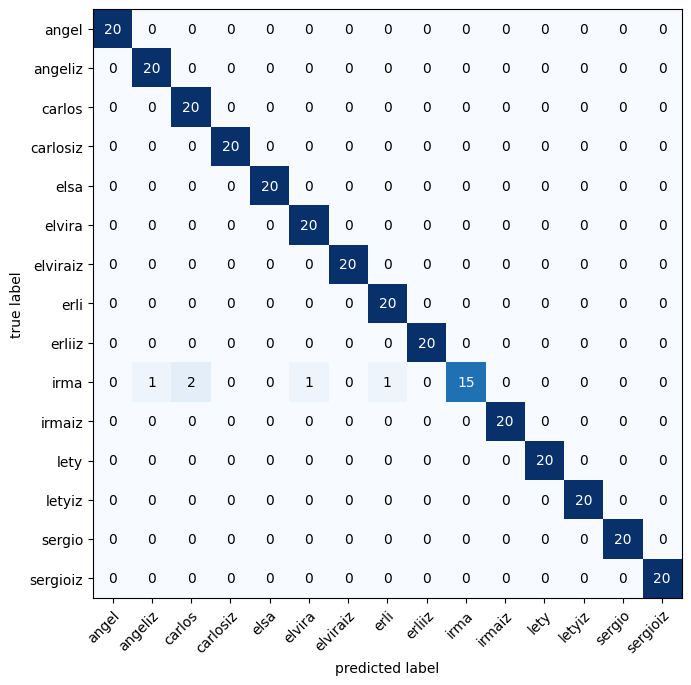

In [35]:
width_shape = 224
height_shape = 224
batch_size = 20
modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloMobileNet_LC.h5'
pesos_modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosMobileNet_LC.h5'
model = load_model(modelo)
model.load_weights(pesos_modelo)
names = ['angel','angeliz','carlos','carlosiz','elsa','elvira','elviraiz','erli','erliiz','irma','irmaiz','lety','letyiz','sergio','sergioiz']

test_data_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/pruebas'  
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(width_shape,height_shape),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',shuffle=False)
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
#print(y_pred)
matc=confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(7,7), class_names =names, show_normed=False)
plt.tight_layout()

## Precisión de cada clase

In [36]:
print(metrics.classification_report(y_real,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     0.9524    1.0000    0.9756        20
           2     0.9091    1.0000    0.9524        20
           3     1.0000    1.0000    1.0000        20
           4     1.0000    1.0000    1.0000        20
           5     0.9524    1.0000    0.9756        20
           6     1.0000    1.0000    1.0000        20
           7     0.9524    1.0000    0.9756        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    0.7500    0.8571        20
          10     1.0000    1.0000    1.0000        20
          11     1.0000    1.0000    1.0000        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    1.0000    1.0000        20
          14     1.0000    1.0000    1.0000        20

    accuracy                         0.9833       300
   macro avg     0.9844    0.9833    0.9824       300
weighted avg     0.9844   

# *Mobilenet - Fine Tune*

## Elaboración del Modelo

In [19]:
image_input = Input(shape=(altura_1, ancho_1, 3))

m_MobileNet = MobileNet(input_tensor=image_input, include_top=False,weights='imagenet')

m_MobileNet.summary()

last_layer = m_MobileNet.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_clases, activation='softmax', name='output')(x)
modeloMobileNet_LC_FT = Model(image_input, out)
modeloMobileNet_LC_FT.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

## Entrenamiento del Modelo

In [20]:
modeloMobileNet_LC_FT.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=lr),metrics=['accuracy'])
modeloMobileNet_LC_FT_history = modeloMobileNet_LC_FT.fit(imagen_entrenamiento,steps_per_epoch=pasos_entrenamiento,
            epochs=epocas,validation_data=imagen_validacion,
            validation_steps=pasos_validacion)

Epoch 1/5
105/105 [==============================] - 215s 2s/step - loss: 1.6284 - accuracy: 0.5033 - val_loss: 1.2239 - val_accuracy: 0.7383
Epoch 2/5
105/105 [==============================] - 251s 2s/step - loss: 0.3679 - accuracy: 0.8881 - val_loss: 0.4547 - val_accuracy: 0.9450
Epoch 3/5
105/105 [==============================] - 248s 2s/step - loss: 0.1987 - accuracy: 0.9438 - val_loss: 0.0891 - val_accuracy: 1.0000
Epoch 4/5
105/105 [==============================] - 247s 2s/step - loss: 0.1318 - accuracy: 0.9614 - val_loss: 0.0266 - val_accuracy: 1.0000
Epoch 5/5
105/105 [==============================] - 248s 2s/step - loss: 0.1014 - accuracy: 0.9733 - val_loss: 0.0182 - val_accuracy: 1.0000


## Gráfica de entrenamiento y validación

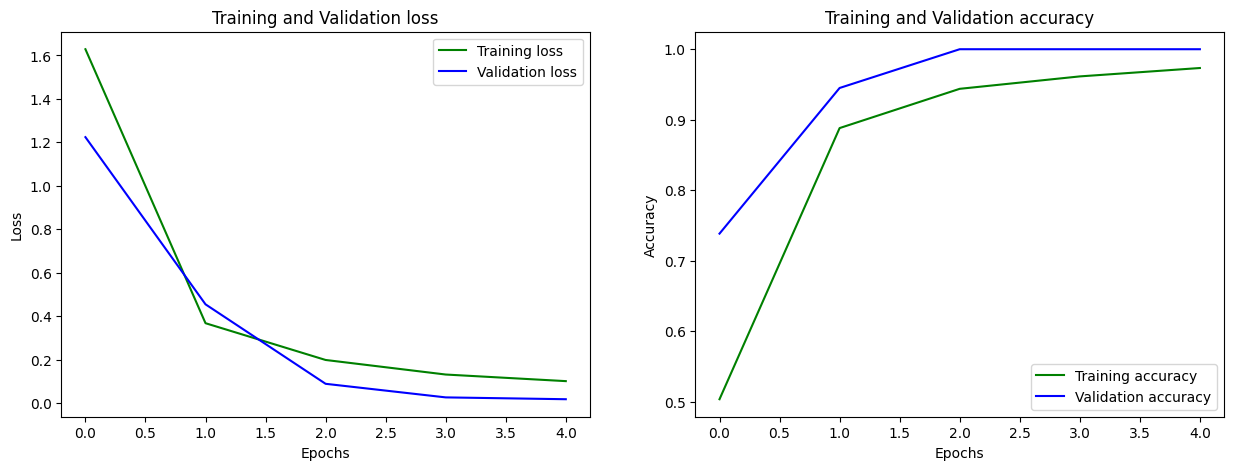

In [21]:
loss_train = modeloMobileNet_LC_FT_history.history['loss']
loss_val = modeloMobileNet_LC_FT_history.history['val_loss']
acc_train = modeloMobileNet_LC_FT_history.history['accuracy']
acc_val = modeloMobileNet_LC_FT_history.history['val_accuracy']
plt.figure(figsize=(15,5))
epochs = range(0,epocas)

plt.subplot(121)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Guardado del modelo con sus respectivos pesos

In [22]:
target_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Fine Tune'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modeloMobileNet_LC_FT.save('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Fine Tune/LC/modeloMobileNet_LC_FT.h5')
modeloMobileNet_LC_FT.save_weights('C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Fine Tune/LC/pesosMobileNet_LC_FT.h5')

## Matriz de confusión

Found 300 images belonging to 15 classes.


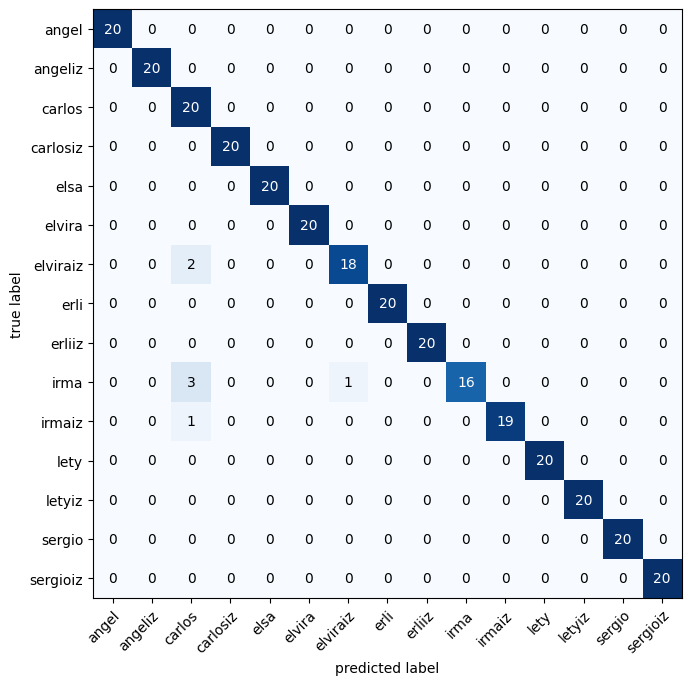

In [23]:
width_shape = 224
height_shape = 224
batch_size = 20
modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Fine Tune/LC/modeloMobileNet_LC_FT.h5'
pesos_modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Fine Tune/LC/pesosMobileNet_LC_FT.h5'
model = load_model(modelo)
model.load_weights(pesos_modelo)
names = ['angel','angeliz','carlos','carlosiz','elsa','elvira','elviraiz','erli','erliiz','irma','irmaiz','lety','letyiz','sergio','sergioiz']

test_data_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/pruebas'  
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(width_shape,height_shape),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',shuffle=False)
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
#print(y_pred)
matc=confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(7,7), class_names =names, show_normed=False)
plt.tight_layout()

## Precisión de cada clase

In [24]:
print(metrics.classification_report(y_real,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     1.0000    1.0000    1.0000        20
           2     0.7692    1.0000    0.8696        20
           3     1.0000    1.0000    1.0000        20
           4     1.0000    1.0000    1.0000        20
           5     1.0000    1.0000    1.0000        20
           6     0.9474    0.9000    0.9231        20
           7     1.0000    1.0000    1.0000        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    0.8000    0.8889        20
          10     1.0000    0.9500    0.9744        20
          11     1.0000    1.0000    1.0000        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    1.0000    1.0000        20
          14     1.0000    1.0000    1.0000        20

    accuracy                         0.9767       300
   macro avg     0.9811    0.9767    0.9771       300
weighted avg     0.9811   

# *AlexNet*

## Elaboración del Modelo

In [5]:
#Creamos un modelo secuencial de AlexNet
model = Sequential()

# 1era Capa Convolucional
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11),strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2da Capa Convolucional
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3era Capa Convolucional
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4ta Capa Convolucional
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5ta Capa Convolucional
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(15))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 23, 23, 256)       0

## Entrenamiento del Modelo

In [7]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=lr),metrics=["accuracy"])
H=model.fit(imagen_entrenamiento,steps_per_epoch=pasos_entrenamiento,
            epochs=epocas,validation_data=imagen_validacion,
            validation_steps=pasos_validacion)

Epoch 1/11
105/105 [==============================] - 111s 1s/step - loss: 2.5806 - accuracy: 0.2195 - val_loss: 2.4574 - val_accuracy: 0.2050
Epoch 2/11
105/105 [==============================] - 134s 1s/step - loss: 1.4031 - accuracy: 0.5667 - val_loss: 1.4224 - val_accuracy: 0.6383
Epoch 3/11
105/105 [==============================] - 131s 1s/step - loss: 0.7992 - accuracy: 0.7957 - val_loss: 0.4377 - val_accuracy: 0.9583
Epoch 4/11
105/105 [==============================] - 167s 2s/step - loss: 0.4927 - accuracy: 0.8914 - val_loss: 0.1527 - val_accuracy: 0.9900
Epoch 5/11
105/105 [==============================] - 144s 1s/step - loss: 0.3311 - accuracy: 0.9348 - val_loss: 0.0854 - val_accuracy: 1.0000
Epoch 6/11
105/105 [==============================] - 160s 2s/step - loss: 0.2167 - accuracy: 0.9705 - val_loss: 0.0631 - val_accuracy: 0.9950
Epoch 7/11
105/105 [==============================] - 159s 2s/step - loss: 0.1922 - accuracy: 0.9724 - val_loss: 0.0587 - val_accuracy: 0.9933

## Gráfica de entrenamiento y validación

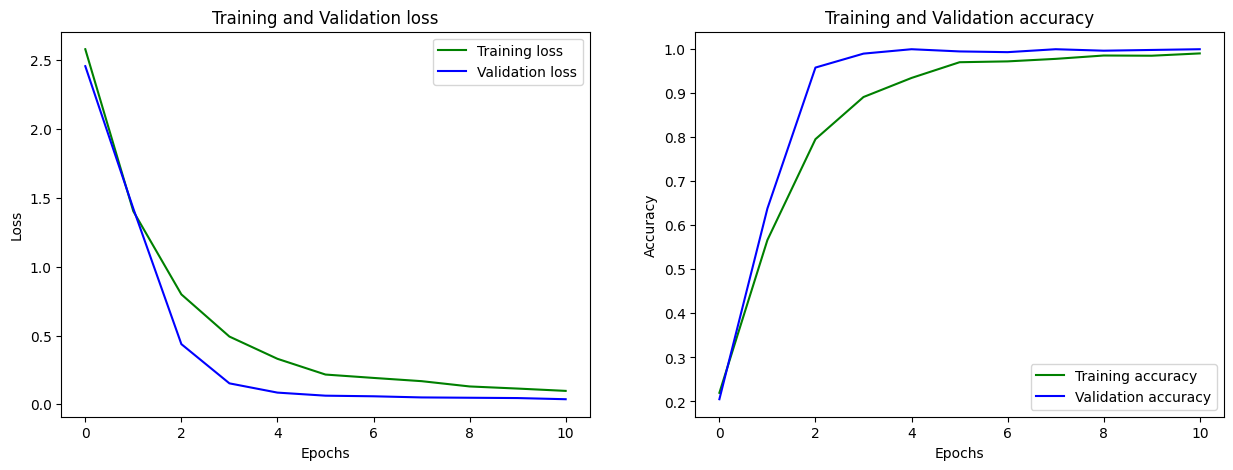

In [8]:
loss_train = H.history['loss']
loss_val = H.history['val_loss']
acc_train = H.history['accuracy']
acc_val = H.history['val_accuracy']
plt.figure(figsize=(15,5))
epochs = range(0,epocas)

plt.subplot(121)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Guardado del modelo con sus respectivos pesos

In [9]:
target_dir = 'C:/Users/Angel Terrones/Desktop/TESIS'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save('C:/Users/Angel Terrones/Desktop/TESIS/modelo15.h5')
model.save_weights('C:/Users/Angel Terrones/Desktop/TESIS/pesos15.h5')

## Matriz de confusión

Found 300 images belonging to 15 classes.


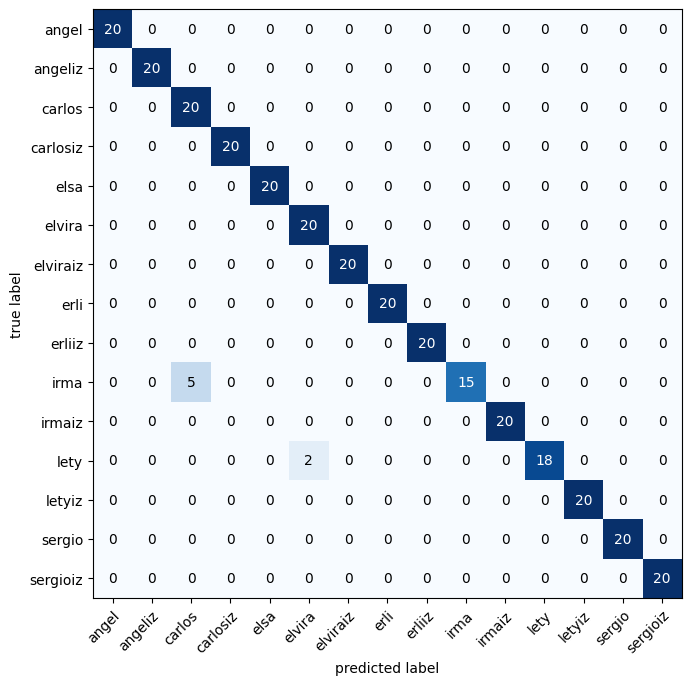

In [36]:
width_shape = 227
height_shape = 227
batch_size = 20
modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/modelo15.h5'
pesos_modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/pesos15.h5'
model = load_model(modelo)
model.load_weights(pesos_modelo)
names = ['angel','angeliz','carlos','carlosiz','elsa','elvira','elviraiz','erli','erliiz','irma','irmaiz','lety','letyiz','sergio','sergioiz']

test_data_dir = 'C:/Users/Angel Terrones/Desktop/TESIS/2. LÍMITES COORDENADAS/pruebas'  
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(width_shape,height_shape),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',shuffle=False)
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
#print(y_pred)
matc=confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(7,7), class_names =names, show_normed=False)
plt.tight_layout()

## Precisión de cada clase

In [37]:
print(metrics.classification_report(y_real,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     1.0000    1.0000    1.0000        20
           2     0.8000    1.0000    0.8889        20
           3     1.0000    1.0000    1.0000        20
           4     1.0000    1.0000    1.0000        20
           5     0.9091    1.0000    0.9524        20
           6     1.0000    1.0000    1.0000        20
           7     1.0000    1.0000    1.0000        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    0.7500    0.8571        20
          10     1.0000    1.0000    1.0000        20
          11     1.0000    0.9000    0.9474        20
          12     1.0000    1.0000    1.0000        20
          13     1.0000    1.0000    1.0000        20
          14     1.0000    1.0000    1.0000        20

    accuracy                         0.9767       300
   macro avg     0.9806    0.9767    0.9764       300
weighted avg     0.9806   

# *Predicción en tiempo real con cámara*

In [5]:
longitud,altura =224,224
batch_size = 20
modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/modeloVGG16_LC.h5'
pesos_modelo = 'C:/Users/Angel Terrones/Desktop/TESIS/5. Pesos Normales/LC/pesosVGG16_LC.h5'
model = load_model(modelo)
model.load_weights(pesos_modelo)
punto1a=10
punto1b=470
punto2a=80
punto2b=600
#Características del texto
ubicacion4 = (20,100)
ubicacion3 = (20,50)
ubicacion = (157,50)
ubicacion2 = (20,620)
font = cv2.FONT_HERSHEY_TRIPLEX
tamañoLetra = 1.1
colorLetra = (0,0,255)
grosorLetra = 2
# COLORES PARA VISUALIZACIÓN
color_contorno_mano = (0,255,0) #Color verde
color_rectangulo = (0,255,255)  #Color amarillo
indice=0
indice_predi=0
pasos_frame=2
frames_guardados=0
bandera2=0
lista=[]
camera = cv2.VideoCapture(1)
while(True):
    _, frame = camera.read()
    frame_rotate = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame_blur_rotate = cv2.GaussianBlur(frame_rotate,(11,11),0)    
    gray  = cv2.cvtColor(frame_blur_rotate, cv2.COLOR_RGB2GRAY)       
    rgb_imagen = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)        
    _,th = cv2.threshold(gray,75,255,cv2.THRESH_BINARY)
    contornos,jerarquia = cv2.findContours(th,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contornos,key=cv2.contourArea,reverse=True)[:1]                 
    final=cv2.bitwise_and(rgb_imagen,rgb_imagen,mask=th)
    final= cv2.cvtColor(final,cv2.COLOR_RGB2GRAY)        
    clahe=cv2.createCLAHE(clipLimit=3,tileGridSize=(8,8))        
    clahe_img=clahe.apply(final)
    RGB  = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB) 
    IMAGEN_FINAL  = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)       
    cv2.rectangle(RGB,(punto1b,punto2b),(punto1a,punto2a),color_rectangulo,1) 
    cv2.drawContours(RGB, cnts,0, color_contorno_mano,1)             
    ########### PUNTOS LÍMITES DE LA MANO ##########

#####################################################################    
######  ALGORITMO PARA DETECTAR CUANDO EXISTE UNA MANO ##############   
##################################################################### 
    lista2=[1]
    bandera=len(contornos)
    for i in range(bandera):
        lista2.append(len(contornos[i]))    
    mayor_contorno=max(lista2)         
#####################################################################
    m=cv2.putText(RGB, str(mayor_contorno), ubicacion2, font, tamañoLetra, colorLetra, grosorLetra)
    lista2=[] # borramos la lista
    if bandera2==0:
        m=cv2.putText(RGB, "  LISTO", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        if mayor_contorno>450:
            if indice % pasos_frame==0:
                if frames_guardados >=40:
                    c = max(contornos, key=cv2.contourArea)        
                    extLeft = tuple(c[c[:, :, 0].argmin()][0])
                    extRight = tuple(c[c[:, :, 0].argmax()][0])
                    extTop = tuple(c[c[:, :, 1].argmin()][0]) 
                    ROI = clahe_img[extTop[1]+90:extTop[1]+260,extLeft[0]+90:extRight[0]-90]   
                    th3 = cv2.adaptiveThreshold(ROI,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,67,2)
                    dilation=cv2.dilate(th3,kernel= np.ones((6,6)),iterations = 1)
                    erosion = cv2.erode(dilation,kernel = np.ones((7,7)),iterations = 1)
                    IMAGEN_TO_SAVE = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
                    IMAGEN_TO_SAVE_RESIZE = cv2.resize(IMAGEN_TO_SAVE, (longitud,altura)) 
                    imagen_array = img_to_array(IMAGEN_TO_SAVE_RESIZE)
                    imagen_array = np.expand_dims(imagen_array, axis=0)
                    prediccion = model.predict(imagen_array)#, batch_size=10
                    prediccion = np.argmax(prediccion)
                    lista.append(prediccion)
                    if frames_guardados>=60:
                        prediccion1=max(lista,key=lista.count)
                        frames_guardados=0
                        indice=0
                        bandera2=1
                        lista=[]
            frames_guardados=frames_guardados+1                
        indice=indice+1    
    m=cv2.putText(RGB, str(frames_guardados), ubicacion3, font, tamañoLetra, colorLetra, grosorLetra)
    m=cv2.putText(RGB, str(indice), ubicacion4, font, tamañoLetra, colorLetra, grosorLetra)    
    if bandera2==1:
        if   prediccion1 == 0:
                m=cv2.putText(RGB, "Angel", ubicacion, font, tamañoLetra, colorLetra, grosorLetra) 
        elif prediccion1 == 1:
                m=cv2.putText(RGB, "Angeliz", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 2:
                m=cv2.putText(RGB, "Carlos", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 3:
                m=cv2.putText(RGB, "Carlosiz", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 4:
                 m=cv2.putText(RGB, "Elsa", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)         
        elif prediccion1 == 5:
                 m=cv2.putText(RGB, "Elvira", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)         
        elif prediccion1 == 6:
                 m=cv2.putText(RGB, "Elviraiz", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 7:
                m=cv2.putText(RGB, "Erli", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 8:
                m=cv2.putText(RGB, "Erliiz", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 9:
                m=cv2.putText(RGB, "Irma", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 10:
                m=cv2.putText(RGB, "Irmaiz", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 11:
                m=cv2.putText(RGB, "Lety", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 12:
                m=cv2.putText(RGB, "Letyiz", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 13:
                m=cv2.putText(RGB, "Sergio", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        elif prediccion1 == 14:
                m=cv2.putText(RGB, "Sergioiz", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        else:
            m=cv2.putText(RGB, "No Detectado", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        
        if indice % pasos_frame==0:
            frames_guardados=frames_guardados+1
        if frames_guardados==25:
            bandera2=0 
            m=cv2.putText(RGB,"          ", ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
            frames_guardados=0
            indice=0
        indice=indice+1    
    
    cv2.imshow('Frame',RGB)    
    key = cv2.waitKey(1)
    if key & 0xFF == ord("2"):        
        break
camera.release()
cv2.destroyAllWindows()